In [1]:
data_dir = r"C:\Users\Tejashvini\Downloads\archive (3)\resized"
import os


from torchvision.datasets import ImageFolder
dataset = ImageFolder(data_dir)
len(dataset)

8683

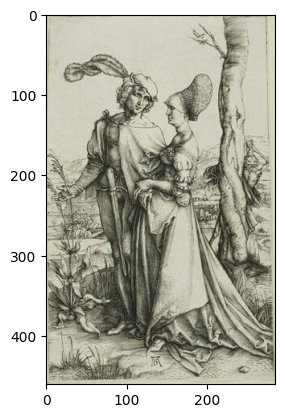

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
img, label = dataset[306]
plt.imshow(img)

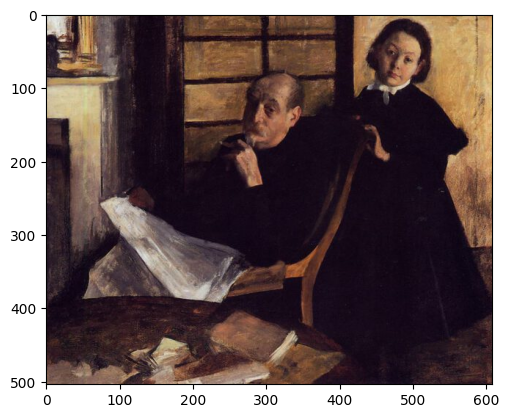

In [17]:
img, label = dataset[1861]
plt.imshow(img)

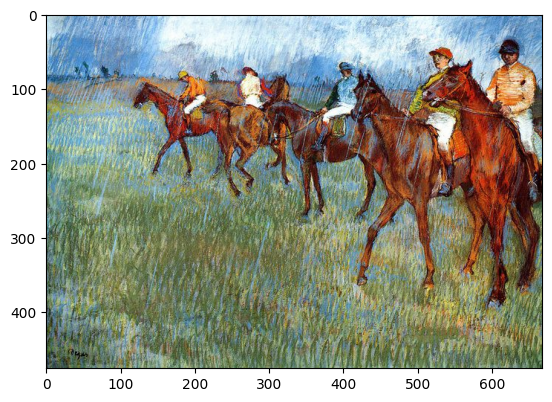

In [18]:
img, label = dataset[1888]
plt.imshow(img)

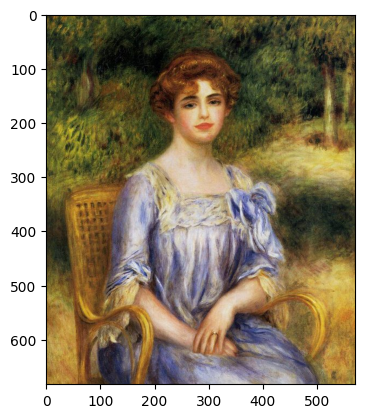

In [20]:
img, label = dataset[6143]
plt.imshow(img)

In [21]:
import torchvision.transforms as tt
from torch.utils.data import DataLoader
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
train_ds = ImageFolder(data_dir, transform=tt.Compose([
tt.Resize(image_size),
tt.CenterCrop(image_size),
tt.ToTensor(),
tt.Normalize(*stats)]))

In [22]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [23]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
from torchvision.utils import make_grid
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [24]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

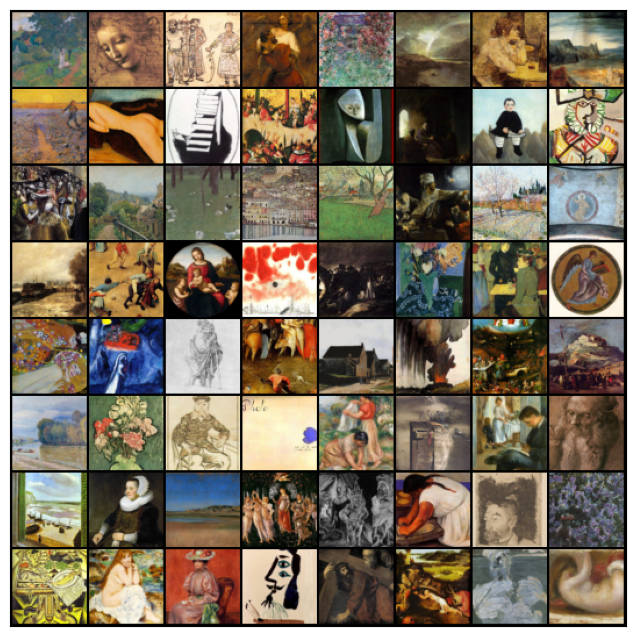

In [25]:
show_batch(train_dl)

In [26]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [27]:
device = get_default_device()
device


device(type='cpu')

In [28]:

train_dl = DeviceDataLoader(train_dl, device)

In [29]:
import torch.nn as nn

In [30]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())


In [31]:
discriminator = to_device(discriminator, device)

In [32]:
latent_size = 128

In [33]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


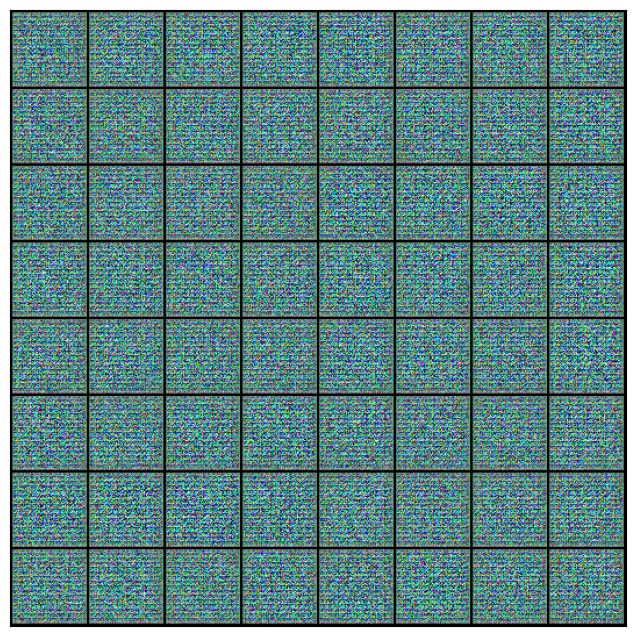

In [34]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [35]:
generator = to_device(generator, device)

In [36]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [37]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [38]:
from torchvision.utils import save_image

In [39]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [40]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [41]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


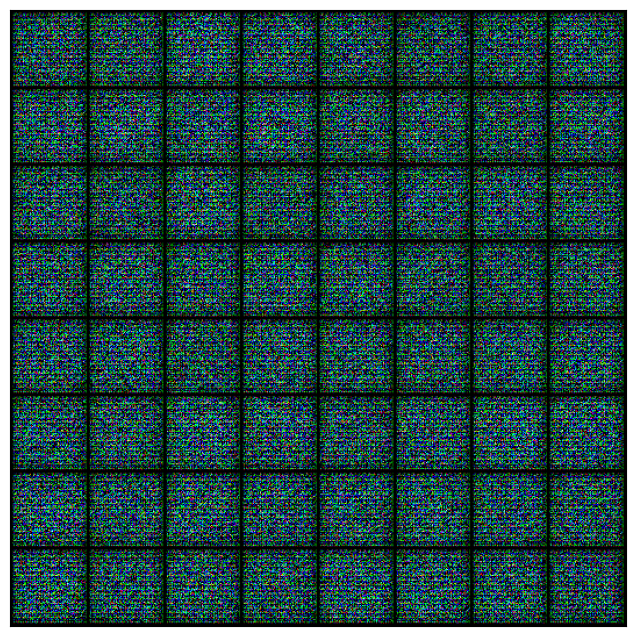

In [42]:
save_samples(0, fixed_latent)

In [43]:
from tqdm.notebook import tqdm
import torch.nn.functional as F


In [44]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [45]:
lr = 0.0002
epochs = 40

In [46]:
history = fit(epochs, lr)

  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [1/40], loss_g: 6.1104, loss_d: 0.5092, real_score: 0.8357, fake_score: 0.2578
Saving generated-images-0001.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [2/40], loss_g: 2.8676, loss_d: 0.3730, real_score: 0.7506, fake_score: 0.0654
Saving generated-images-0002.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [3/40], loss_g: 5.7014, loss_d: 0.0684, real_score: 0.9640, fake_score: 0.0302
Saving generated-images-0003.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [4/40], loss_g: 2.1687, loss_d: 0.2748, real_score: 0.7972, fake_score: 0.0247
Saving generated-images-0004.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [5/40], loss_g: 2.8458, loss_d: 0.6546, real_score: 0.6426, fake_score: 0.1560
Saving generated-images-0005.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [6/40], loss_g: 3.4706, loss_d: 0.5979, real_score: 0.6254, fake_score: 0.0202
Saving generated-images-0006.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [7/40], loss_g: 3.0388, loss_d: 0.7090, real_score: 0.5850, fake_score: 0.0277
Saving generated-images-0007.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [8/40], loss_g: 2.0778, loss_d: 0.7381, real_score: 0.5749, fake_score: 0.0787
Saving generated-images-0008.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [9/40], loss_g: 4.3307, loss_d: 0.1976, real_score: 0.9706, fake_score: 0.1483
Saving generated-images-0009.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [10/40], loss_g: 4.3433, loss_d: 0.2810, real_score: 0.9137, fake_score: 0.1627
Saving generated-images-0010.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [11/40], loss_g: 4.3980, loss_d: 0.3379, real_score: 0.8776, fake_score: 0.1595
Saving generated-images-0011.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [12/40], loss_g: 3.7614, loss_d: 0.3535, real_score: 0.7418, fake_score: 0.0325
Saving generated-images-0012.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [13/40], loss_g: 2.7866, loss_d: 0.4308, real_score: 0.7488, fake_score: 0.0975
Saving generated-images-0013.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [14/40], loss_g: 3.4763, loss_d: 0.2440, real_score: 0.9125, fake_score: 0.1231
Saving generated-images-0014.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [15/40], loss_g: 1.9531, loss_d: 0.6800, real_score: 0.6168, fake_score: 0.1062
Saving generated-images-0015.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [16/40], loss_g: 2.4233, loss_d: 0.5910, real_score: 0.6593, fake_score: 0.0794
Saving generated-images-0016.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [17/40], loss_g: 2.2969, loss_d: 0.3840, real_score: 0.8321, fake_score: 0.1609
Saving generated-images-0017.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [18/40], loss_g: 2.5275, loss_d: 0.7688, real_score: 0.5684, fake_score: 0.1018
Saving generated-images-0018.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [19/40], loss_g: 4.2500, loss_d: 0.3919, real_score: 0.8314, fake_score: 0.1633
Saving generated-images-0019.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [20/40], loss_g: 5.2850, loss_d: 0.8227, real_score: 0.8391, fake_score: 0.4385
Saving generated-images-0020.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [21/40], loss_g: 5.4487, loss_d: 0.7502, real_score: 0.9489, fake_score: 0.4668
Saving generated-images-0021.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [22/40], loss_g: 4.2615, loss_d: 0.5966, real_score: 0.8404, fake_score: 0.3005
Saving generated-images-0022.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [23/40], loss_g: 4.0193, loss_d: 0.4359, real_score: 0.8621, fake_score: 0.2271
Saving generated-images-0023.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [24/40], loss_g: 4.0896, loss_d: 2.4952, real_score: 0.1233, fake_score: 0.0007
Saving generated-images-0024.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [25/40], loss_g: 5.7607, loss_d: 0.7781, real_score: 0.8713, fake_score: 0.4206
Saving generated-images-0025.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [26/40], loss_g: 2.9827, loss_d: 0.2280, real_score: 0.8981, fake_score: 0.1051
Saving generated-images-0026.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [27/40], loss_g: 3.1451, loss_d: 0.3310, real_score: 0.9311, fake_score: 0.2122
Saving generated-images-0027.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [28/40], loss_g: 4.5634, loss_d: 0.4643, real_score: 0.8664, fake_score: 0.2468
Saving generated-images-0028.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [29/40], loss_g: 4.0701, loss_d: 0.2693, real_score: 0.8721, fake_score: 0.1124
Saving generated-images-0029.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [30/40], loss_g: 6.3666, loss_d: 0.5979, real_score: 0.8975, fake_score: 0.3557
Saving generated-images-0030.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [31/40], loss_g: 4.3021, loss_d: 0.4078, real_score: 0.9071, fake_score: 0.2389
Saving generated-images-0031.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [32/40], loss_g: 7.4075, loss_d: 0.8088, real_score: 0.9424, fake_score: 0.4835
Saving generated-images-0032.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [33/40], loss_g: 2.9823, loss_d: 0.4648, real_score: 0.8043, fake_score: 0.1857
Saving generated-images-0033.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [34/40], loss_g: 5.9296, loss_d: 0.4786, real_score: 0.9575, fake_score: 0.3281
Saving generated-images-0034.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [35/40], loss_g: 3.5434, loss_d: 0.3108, real_score: 0.8591, fake_score: 0.1266
Saving generated-images-0035.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [36/40], loss_g: 2.9948, loss_d: 0.4424, real_score: 0.7633, fake_score: 0.1211
Saving generated-images-0036.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [37/40], loss_g: 3.3232, loss_d: 0.3262, real_score: 0.8187, fake_score: 0.0996
Saving generated-images-0037.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [38/40], loss_g: 3.3281, loss_d: 0.5059, real_score: 0.8477, fake_score: 0.2622
Saving generated-images-0038.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [39/40], loss_g: 3.0090, loss_d: 0.3916, real_score: 0.7182, fake_score: 0.0318
Saving generated-images-0039.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [40/40], loss_g: 3.1878, loss_d: 0.4619, real_score: 0.8939, fake_score: 0.2678
Saving generated-images-0040.png


In [47]:
losses_g, losses_d, real_scores, fake_scores = history

In [48]:
# Save the model checkpoints
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [49]:
from IPython.display import Image

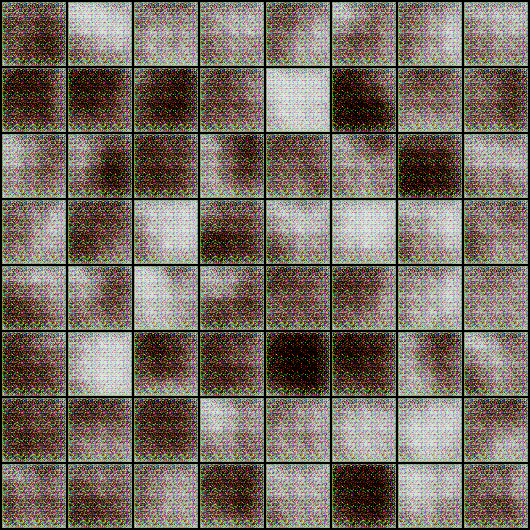

In [50]:
Image('./generated/generated-images-0001.png')

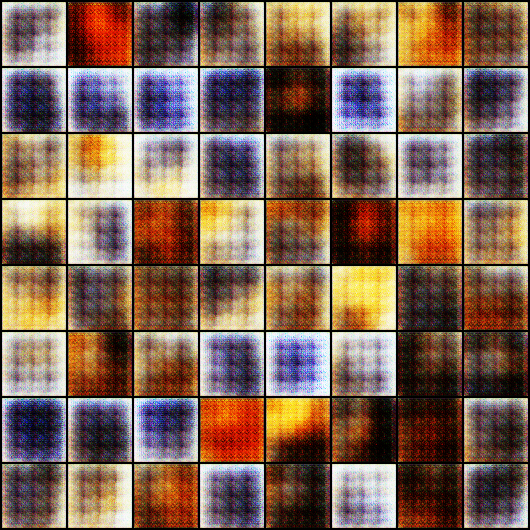

In [51]:
Image('./generated/generated-images-0005.png')

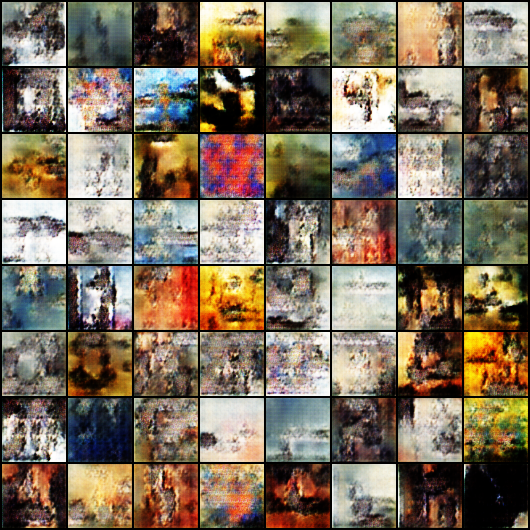

In [52]:
Image('./generated/generated-images-0040.png')

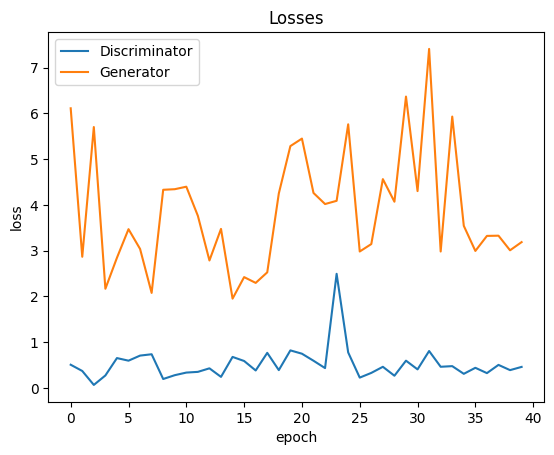

In [53]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

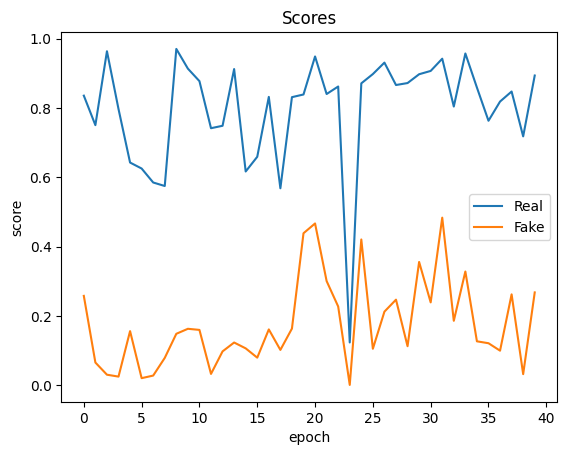

In [54]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');